In [ ]:
## Imports
# tf
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
# others
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
from glob import glob
import os
import time

In [ ]:
## variables
IMG_SIZE = (256,256,3)
EPOCH = 200
LATENT_DIM = 100
BATCH_SIZE = 256
EPOCH_SIZE = 50000 # how many imgs in each epoch 
SEED_SIZE = 16 # how many pictures to track progress of
ALTERNATOR = 3 # times generator gets trained | each time discriminator gets trained

# path 
img_path = "./DCGAN"
data_path = "./data.npy"

In [ ]:
def process_images(in_path, out_path):
  input_dir_error = not os.path.isdir(in_path)
  output_file_exist = os.path.isfile(out_path)

  if output_file_exist:
    print("Output file already exists, loading...")
    dataset = np.load(out_path)
  elif input_dir_error:
    print("Error: input path error")
    return None

  else:  
    image_files = glob(in_path + '/*.jpg')
    # main loop
    i = 0
    dataset = []
    for img in image_files:
      new_img = image.load_img(img)
      new_img = np.asarray(new_img)
      new_img = tf.image.resize(new_img, [IMG_SIZE[0],IMG_SIZE[1]])
      dataset.append(new_img)
      # track progress
      i += 1
      if i%500 == 0:
        print("Pictures processed: ", i)
    # scale and save
    dataset = np.array(dataset)
    dataset = dataset / 255 * 2 - 1
    np.save(out_path, dataset)
    print(f'Coverted {len(image_files)} images')

  print("data preparation finish")
  return dataset

In [ ]:
# process_images and load data
prepared_data = process_images(img_path, data_path) # used for creating training/testing set
data_shape = prepared_data.shape
print(f'shape of the data is {data_shape}')

data_train = tf.data.Dataset.from_tensor_slices(prepared_data).shuffle(EPOCH_SIZE).batch(BATCH_SIZE)
del prepared_data

Pictures processed:  500
Pictures processed:  1000
Pictures processed:  1500
Pictures processed:  2000
Pictures processed:  2500
Pictures processed:  3000
Pictures processed:  3500
Pictures processed:  4000
Pictures processed:  4500
Coverted 4990 images
data preparation finish
shape of the data is (4990, 256, 256, 3)


In [ ]:
# global variable: LATENT_DIM
def create_generator():
  i = layers.Input(shape=(LATENT_DIM,))
  x = layers.Dense(4*4*512, use_bias=False, activation=layers.LeakyReLU(alpha = 0.2))(i)
  x = layers.Reshape((4, 4, 512))(x)
  x = layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation=layers.LeakyReLU(alpha = 0.2))(x)
  # 8, 8, 256
  x = layers.BatchNormalization(momentum = 0.7)(x)
  x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation=layers.LeakyReLU(alpha = 0.2))(x)
  # 16, 16, 128
  x = layers.BatchNormalization(momentum = 0.7)(x)
  x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation=layers.LeakyReLU(alpha = 0.2))(x)
  # 32, 32, 64
  x = layers.BatchNormalization(momentum = 0.7)(x)
  x = layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation=layers.LeakyReLU(alpha = 0.2))(x)
  # 64, 64, 32
  x = layers.BatchNormalization(momentum = 0.7)(x)
  x = layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation=layers.LeakyReLU(alpha = 0.2))(x)
  # 128, 128, 16
  x = layers.BatchNormalization(momentum = 0.7)(x)
  x = layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)
  # 256, 256, 3, must match IMG_SIZE

  model = Model(i, x)
  return model
  

In [ ]:
# global variable: IMG_SIZE
def create_discriminator():
  i = layers.Input(shape=IMG_SIZE)
  x = layers.Conv2D(16, (5, 5), strides=(2, 2), padding='same', activation=layers.LeakyReLU(alpha=0.2))(i)
  x = layers.Dropout(0.2)(x)
  x = layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', activation=layers.LeakyReLU(alpha=0.2))(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', activation=layers.LeakyReLU(alpha=0.2))(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', activation=layers.LeakyReLU(alpha=0.2))(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(1, activation='sigmoid')(x)
  
  model = Model(i, x)
  return model

In [ ]:
## Setting up models and define loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real, fake):
  loss_real = cross_entropy(tf.ones_like(real), real)
  loss_fake = cross_entropy(tf.zeros_like(fake), fake)
  loss_total = loss_real + loss_fake
  return loss_total

def generator_loss(fake):
    return cross_entropy(tf.ones_like(fake), fake)

generator_optimizer = Adam(0.0001, 0.5)
discriminator_optimizer = Adam(0.0001, 0.5)

generator = create_generator()
discriminator = create_discriminator()

In [ ]:
# global variable: BATCH_SIZE ,LATENT_DIM, generator, discriminator
@tf.function
def train_both(imgs):
  noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_imgs = generator(noise)
    output_real = discriminator(imgs)
    output_fake = discriminator(generated_imgs)
    loss_gen = generator_loss(output_fake)
    loss_disc = discriminator_loss(output_real, output_fake)
  grad_gen = gen_tape.gradient(loss_gen, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(grad_gen, generator.trainable_variables))

  grad_disc = disc_tape.gradient(loss_disc, discriminator.trainable_variables)
  discriminator_optimizer.apply_gradients(zip(grad_disc, discriminator.trainable_variables))

  return loss_gen, loss_disc

In [ ]:
# global variable: BATCH_SIZE ,LATENT_DIM, generator, discriminator
@tf.function
def train_gen_only(imgs):
  noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_imgs = generator(noise)
    output_real = discriminator(imgs)
    output_fake = discriminator(generated_imgs)
    loss_gen = generator_loss(output_fake)
    loss_disc = discriminator_loss(output_real, output_fake)
  grad_gen = gen_tape.gradient(loss_gen, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(grad_gen, generator.trainable_variables))
  
  return loss_gen, loss_disc

In [ ]:
# global variable: EPOCH
def train(dataset):
  for i in range(1, EPOCH+1):
    start = time.time() # for testing
    loss_list_gen = []
    loss_list_disc = []

    j = 0 # alternate to train discriminator every other step
    for batch in dataset:
      if j == 0:
        loss_gen, loss_disc = train_both(batch)
      else:
        loss_gen, loss_disc = train_gen_only(batch)
      j = (j + 1) % ALTERNATOR

      loss_list_gen.append(loss_gen)
      loss_list_disc.append(loss_disc)
    
    epoch_loss_gen = sum(loss_list_gen) / len(loss_list_gen)
    epoch_loss_disc = sum(loss_list_disc) / len(loss_list_disc)

    print(f'Epoch {i}: Time Spent ({time.time()-start}), gen loss ({epoch_loss_gen}), disc loss ({epoch_loss_disc})' ) # for testing

In [ ]:
# RUN TRAINING
train(data_train)

Epoch 1: Time Spent (55.32725119590759), gen loss (0.6381602883338928), disc loss (1.3114049434661865)
Epoch 2: Time Spent (24.828988552093506), gen loss (0.3479743003845215), disc loss (1.7916295528411865)
Epoch 3: Time Spent (18.412721395492554), gen loss (0.5976845026016235), disc loss (1.4877759218215942)
Epoch 4: Time Spent (18.678858041763306), gen loss (0.6820942759513855), disc loss (1.4595589637756348)
Epoch 5: Time Spent (19.034754514694214), gen loss (0.8722567558288574), disc loss (1.336885690689087)
Epoch 6: Time Spent (19.404022932052612), gen loss (0.9386941194534302), disc loss (1.2330282926559448)
Epoch 7: Time Spent (19.075030088424683), gen loss (0.9849052429199219), disc loss (1.4179248809814453)
Epoch 8: Time Spent (18.634232997894287), gen loss (0.9955031275749207), disc loss (1.3132679462432861)
Epoch 9: Time Spent (18.655338287353516), gen loss (1.0813674926757812), disc loss (1.0051274299621582)
Epoch 10: Time Spent (19.114649534225464), gen loss (0.82200926542

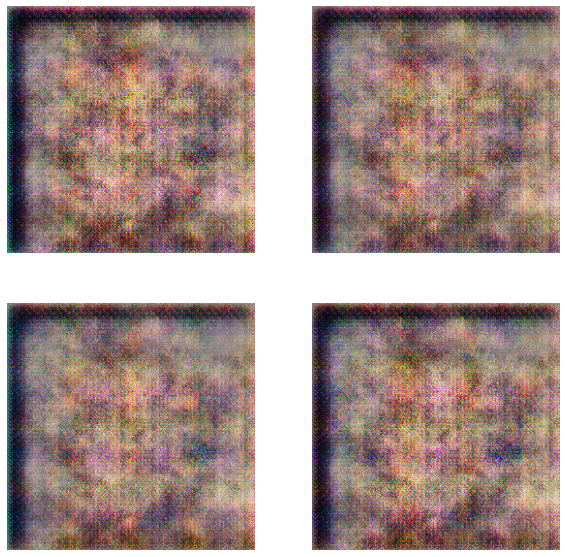

In [ ]:
# see result
noise = tf.random.normal([4,LATENT_DIM])
generated_image = generator(noise, training=False)
generated_image = generated_image / 2 + 0.5

fig = plt.figure(figsize=(10,10))
for i in range(generated_image.shape[0]):
  plt.subplot(2,2, i+1)
  plt.imshow(generated_image[i])
  plt.axis('off')
plt.show()


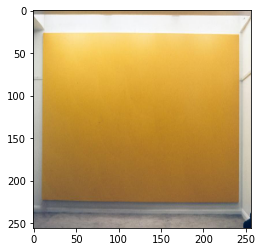

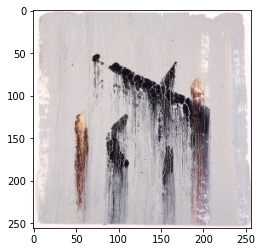

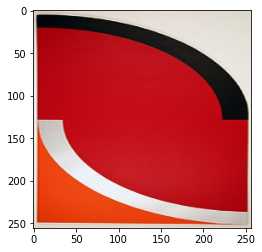

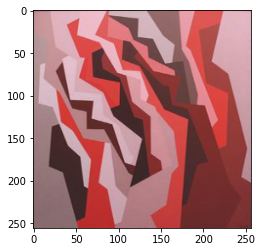

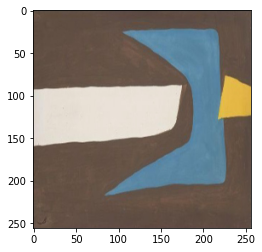

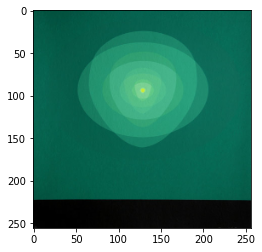

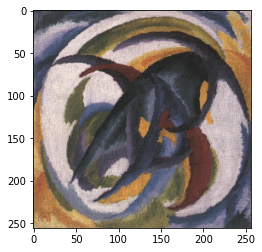

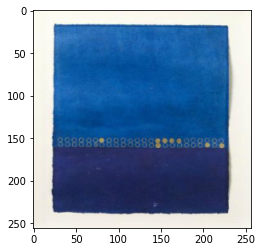

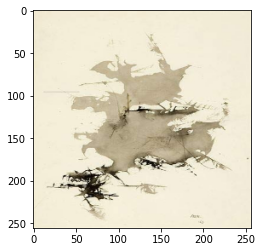

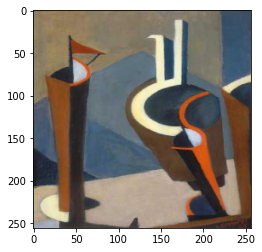

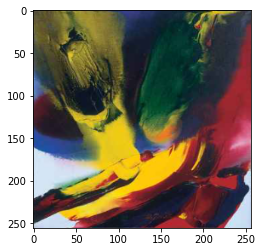

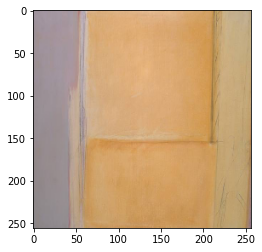

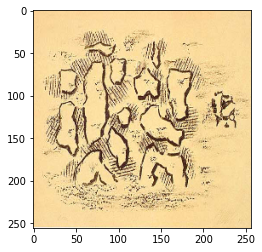

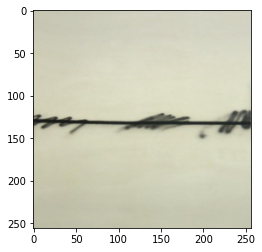

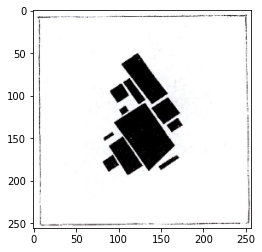

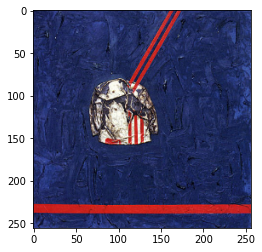

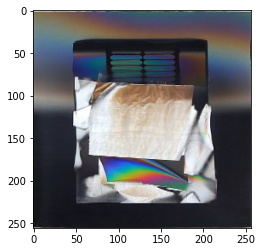

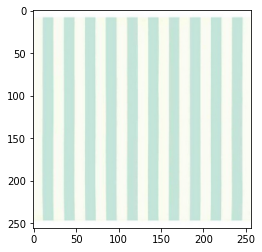

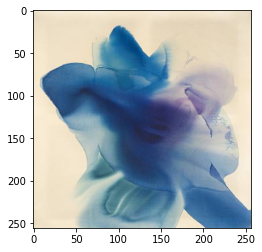

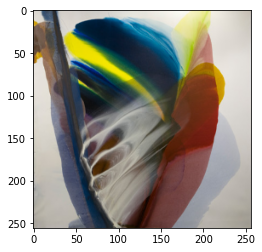

In [ ]:
# print(generated_image[0])
# print(generated_image[1])
for batch in data_train:
  random_img = batch[0] / 2 + 0.5
  plt.imshow(random_img)
  plt.show()

(4990, 256, 256, 3)


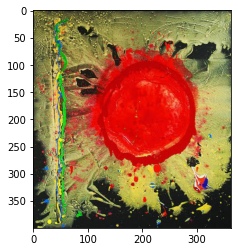

In [ ]:
# test image
image_test = glob(img_path + '/*.jpg')
# resize_test = glob(resize_img_path + '/*.jpg')

print(data_shape)

random_img = image.load_img(np.random.choice(image_test))
plt.imshow(random_img)
plt.show()

# random_img = prepared_data[np.random.choice(data_shape[0])]
# random_img = random_img / 2 + 0.5
# plt.imshow(random_img)
# plt.show()